# Spike Inference

Using a Bi-Directional LSTM to predict spikes from LFP data

## 
+ Leonardo Ferrisi
+ Alana Maluszczak
+ Daniel Feldman

In [3]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Bidirectional, LSTM, Dropout, Dense, LayerNormalization
from keras.optimizers import Adam
from keras.regularizers import l2
import time


In [4]:
def create_sequences(signal, labels, window_size):
    """
    Create sequences from the 1D time series signal.
    For each window of LFP data, the label is the spike value at the time immediately after the window.
    """
    X, y = [], []
    for i in range(len(signal) - window_size):
        X.append(signal[i : i + window_size])
        y.append(labels[i + window_size])
    return np.array(X), np.array(y)

In [5]:
# ------------------------------
# 1. Data Loading and Preprocessing
# ------------------------------
# Change the data_dir and filename as needed.
data_dir = "./data"
filename = "fake_lfp_data.csv"  # CSV file generated previously
data_path = os.path.join(data_dir, filename)

if not os.path.exists(data_path):
    print(f"Data file {data_path} not found. Please ensure the CSV exists.")
    raise Exception("Data file not found")

# Read the CSV file; expecting columns: 'time', 'lfp', and 'spike'
df = pd.read_csv(data_path)

# Extract the LFP and spike columns (assuming LFP is our feature and spike is our label)
lfp = df['lfp'].values
spike = df['spike'].values

In [6]:
# ------------------------------
# 2. Creating Sequences for the LSTM
# ------------------------------
# Define a window size (number of timesteps per sample)
window_size = 100  # You can adjust this based on your sampling rate & desired context

# Create sequences using the sliding window approach.
# The label for each sequence is the spike value immediately after the window.
X, y = create_sequences(lfp, spike, window_size)

# Reshape X to have shape (samples, timesteps, features). In this case, features=1.
X = X.reshape(-1, window_size, 1)

print("Data shapes:")
print("X:", X.shape)
print("y:", y.shape)

Data shapes:
X: (9900, 100, 1)
y: (9900,)


In [7]:
# ------------------------------
# 3. Splitting the Dataset: 70% Training, 30% Validation
# ------------------------------
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.3, random_state=42
)

print(f"Training set shape: X_train={X_train.shape}, y_train={y_train.shape}")
print(f"Validation set shape: X_val={X_val.shape}, y_val={y_val.shape}")

Training set shape: X_train=(6930, 100, 1), y_train=(6930,)
Validation set shape: X_val=(2970, 100, 1), y_val=(2970,)


In [9]:
# ------------------------------
# 4. Building the Bidirectional LSTM Model
# ------------------------------
input_timesteps = X_train.shape[1]
input_features = X_train.shape[2]

model = Sequential([
    # First Bidirectional LSTM layer; return_sequences=True to allow stacking
    Bidirectional(LSTM(64, return_sequences=True), input_shape=(input_timesteps, input_features)),
    Dropout(0.2),
    
    # Second Bidirectional LSTM layer; return_sequences=False as it's the last LSTM layer
    Bidirectional(LSTM(32, return_sequences=False)),
    Dropout(0.2),
    
    # Final Dense layer for binary classification (predicting spike or no spike)
    Dense(1, activation='sigmoid')
])


time_start_model = time.time()

model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
model.summary()

time_end_model = time.time()
print(f"Model building time: {time_end_model - time_start_model} seconds")

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_2 (Bidirectional) │ (None, 100, 128)       │        33,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 100, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 75,073 (293.25 KB)

 Trainable params: 75,073 (293.25 KB)

 Non-trainable params: 0 (0.00 B)

Model building time: 0.014992952346801758 seconds


In [10]:
# ------------------------------
# 5. Training the Model
# ------------------------------

time_start_training = time.time()

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,         # Adjust the number of epochs as needed
    batch_size=64,     # Adjust batch size as needed
    verbose=1
)

time_end_training = time.time()
print(f"Model training time: {time_end_training - time_start_training} seconds")

Epoch 1/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 17s 99ms/step - accuracy: 0.8812 - loss: 0.3597 - val_accuracy: 0.9212 - val_loss: 0.2057
Epoch 2/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 10s 92ms/step - accuracy: 0.9261 - loss: 0.1928 - val_accuracy: 0.9152 - val_loss: 0.1942
Epoch 3/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 10s 91ms/step - accuracy: 0.9242 - loss: 0.1829 - val_accuracy: 0.9229 - val_loss: 0.1769
Epoch 4/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 10s 94ms/step - accuracy: 0.9255 - loss: 0.1770 - val_accuracy: 0.9229 - val_loss: 0.1863
Epoch 5/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 10s 95ms/step - accuracy: 0.9281 - loss: 0.1690 - val_accuracy: 0.9246 - val_loss: 0.1724
Epoch 6/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 10s 95ms/step - accuracy: 0.9285 - loss: 0.1644 - val_accuracy: 0.9256 - val_loss: 0.1673
Epoch 7/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 10s 94ms/step - accuracy: 0.9285 - loss: 0.1672 - val_accuracy: 0.9253 - val_loss: 0.1701
Epoch 8/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 11s 96ms/step - accuracy: 0.9260 - loss: 0.1676 - 

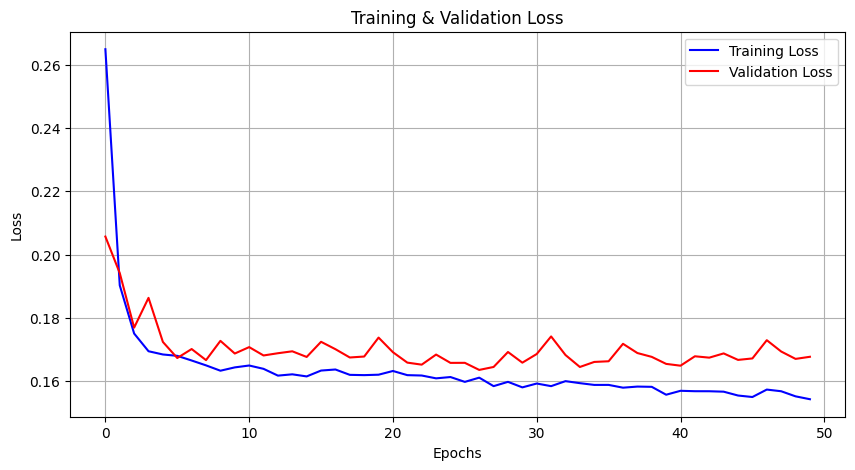

In [11]:
# ------------------------------
# 6. Plotting Training History
# ------------------------------
# Plot Training & Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()
plt.grid()
plt.show()

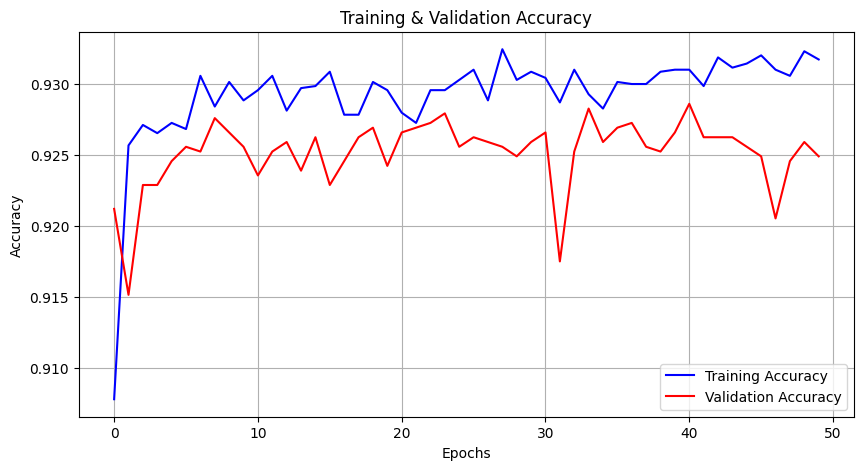

In [12]:
# Plot Training & Validation Accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()
plt.grid()
plt.show()